In [5]:
import numpy as np
import pandas as pd
import nltk
from nltk.collocations import *
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import euclidean_distances

import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
data = pd.read_csv('Emails.csv')
data.head()

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,...,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,...,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...
3,4,C05739550,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550...,F-2015-04841,...,NaN,"Mills, Cheryl D <MillsCD@state.gov>","Mitchell, Andrew B","Wednesday, September 12,2012 12:44 PM",F-2015-04841,C05739550,05/13/2015,RELEASE IN PART,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
4,5,C05739554,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,80.0,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739554...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739554,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.com>\nFriday, March 11,...",B6\nUNCLASSIFIED\nU.S. Department of State\nCa...


In [113]:
X = data.ExtractedBodyText.dropna().values
# X = data.RawText.dropna().values
X.shape

(6742,)

In [114]:
for i in np.random.randint(1,X.shape[0], 10):
    x = X[i]
    print x, '\n'

Abedin, Huma <AbedinH@state.gov>
Sunday, August 30, 2009 1:02 PM
H
Re: Turkey-Armenia text for Davutoglu call
B6 

High Representative and 3 State Secretaries)
Importance: High
Haiti Donor Conference Update.
See below.
We have calls for you to call Qatar and UAE for funds (also on your call sheet was Saudis and Kuwait — have not seen
them register yet nor have they told our embassies yet).
Also — am going to head to Haiti for day on the CoDEL and sit with GOH on the development authority — just had long
convo with WJC.
cdm 

Is there a backstory? 

See below.
cdm 

14.0 

FYI 

Not sure if u r still up but I left the tomorrows bfg binder outside your door.
57 

Hrc is going to be in dc tomorrow. Taking the 2pm shuttle. 

Thx. 

I have a cell that has changed. Tracking down new one 



Удалим лишние строки из писем, такие как дата и время письма, получатель, подпись и прочую служебную информацию

In [115]:
# 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 
#                   'October', 'November', 'December',
#                   'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
starting_words = [                  'UNCLASSIFIED', 'STATE DEPT', 'SUBJECT TO', 'RELEASE',
                  'H ', 'Case', 'From', 'To', 'Sent', 'Date', 'Doc', 'U.S. Department', '\x0c',  'Cc', 'Re', 'cc']

def not_extra_line(line):
    for w in starting_words:
        if line.startswith(w):
            return False
    return True

In [116]:
np.random.randint(1,X.shape[0], 10)

array([1715, 4430,  756, 4677, 6600, 1535, 3677, 3302, 1954, 4895])

In [117]:
X_new = map(lambda x: '\n'.join(filter(not_extra_line, x.split('\n'))), X)
for i in np.random.randint(1,X.shape[0], 10):
    x = X_new[i]
    print x, '\n'

McHale, Judith A <McHaleJA@state.gov>
Friday, April 9, 2010 6:54 AM
H.
Mills, Cheryl D; Sullivan, Jacob J
RE: recognition of USG assistance/contributions.
Will do. This is such a critical (and frustrating) issue that I want to try and start moving forward on it as soon as we can. I
know Raj wants to address this as well. I'd like to start off with a relatively small group of DoS and USAID reps, plus a
group top private sector brand and other ex erts. For exam .l
who is an incredible woman who is already helping me with youth engagement and who would B6
be terrific for this. In addition I'd like to reach out to people in the NGO and think tank community so we can get a broad
range of opinions.
Will keep you posted.
There is a difference of opinion within NEA that I am trying to sort out B5
but I will have something to you by next early week.
Finally, as I think you know,
I am working on a memo for you and Jim outlining the details.
im 

Also give a copy to EAP rep who will be at mtg. 



Оставим только слова (из букв)

In [118]:
from nltk.tokenize import RegexpTokenizer
import re
tokenizer = RegexpTokenizer('[a-zA-Z]+')
X_new = map(lambda x: ' '.join(tokenizer.tokenize(x)), X_new)
for i in np.random.randint(1,X.shape[0], 10):
    x = X_new[i]
    print x, '\n'

Tuesday June AM pverveer Very distressing report If I go to Ukraine in early July are you going w me What could I do to address Let s raise w Phil Gordon today 

 

Jiloty Lauren C JilotyLC state gov Saturday September PM Huma Abedin H I have a home number 

Kerry 

I don t recall hearing about this particular project before Can you do a quick analysis before I follow up 

am PRESIDENTIAL DAILY BRIEFING am Secretary s Office am DAILY SMALL STAFF MEETING am Secretary s Office am DAILY SENIOR STAFF MEETING am Secretary s Conference Room am REMARKS TO THE DIPLOMACY CONFERENCE ON LATIN am AMERICA Marshall Auditorium am PHONE CALL w FRENCH FM BERNARD KOUCHNER am Secretary s Office am PHONE CALL w DR HENRY KISSINGER am Secretary s Office am SPEECH PREP TIME am Secretary s Office am WEEKLY MEETING w UN AMBASSADOR SUSAN RICE pm Secretary s Office pm PRE BRIEF FOR KISSINGER INTERVIEW pm Secretary s Office Jake PJ and Philippe pm PRIVATE MEETING w Joe Wilson pm Secretary s Office pm HOLIDAY RECE

К нижнему регистру приведет векторайзер

In [119]:
words = [word for l in map(lambda s: s.split(), X_new) for word in l]

In [120]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(words)
finder.nbest(bigram_measures.pmi, 5)

[('AAAAAAAABHM', 'UucITWnkilM'),
 ('ACFE', 'ASIS'),
 ('AEA', 'Investors'),
 ('AFFINITY', 'GROUPS'),
 ('AFL', 'CIO')]

Нашли коллокации из редких слов - не очень интересно.

Найдём топовую биграму при помощи CountVectorizer-а.

In [121]:
vectorizer = CountVectorizer(ngram_range=(2,2))
X_vectorized = vectorizer.fit_transform(X_new)
bigram_counts = np.array(X_vectorized.sum(axis=0))[0]
best_bigram_id = bigram_counts.argmax()
filter(lambda s: vectorizer.vocabulary_[s] == best_bigram_id, vectorizer.vocabulary_.keys())[0]

u'of the'

In [122]:
%%time
vect = TfidfVectorizer(max_features=2000, min_df=50, max_df=0.5, binary=True)
# vect = CountVectorizer(max_features=2000, min_df=50, max_df=0.5, binary=True)
X_vectorized = np.array(vect.fit_transform(X_new).todense())

CPU times: user 420 ms, sys: 8 ms, total: 428 ms
Wall time: 408 ms


In [142]:
%%time
kmeans = KMeans(n_clusters=15)
y = kmeans.fit_predict(X_vectorized)
# %time y = DBSCAN(eps=0.4, min_samples=50, metric='cosine', algorithm='brute').fit_predict(X_vectorized)
# %time y = AgglomerativeClustering(n_clusters=10).fit_predict(X_vectorized)

CPU times: user 10.2 s, sys: 4.58 s, total: 14.8 s
Wall time: 9.52 s


In [143]:
num_classes = np.unique(y).shape[0]
pd.Series(y).value_counts()

5     1564
9     1379
14     676
6      543
4      498
0      468
11     421
12     366
13     165
7      159
2      134
8      117
3      100
10      82
1       70
dtype: int64

In [144]:
%time X2 = PCA(n_components=2).fit_transform(X_vectorized)
# %time X2 = TSNE(n_components=2).fit_transform(X_vectorized)

CPU times: user 604 ms, sys: 1.76 s, total: 2.37 s
Wall time: 364 ms


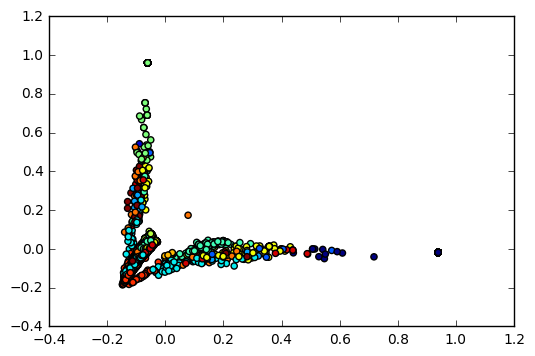

In [145]:
plt.scatter(X2[:, 0], X2[:, 1], c=y)
plt.show()

Для каждого клаccа (кластера) изобразим семплы наиболее близкие к центру

In [160]:
for cls, center in enumerate(kmeans.cluster_centers_):
    print '\nCLASS {}\n'.format(cls)
    dists = euclidean_distances(X_vectorized, [center])
    dists[y != cls] = 1e9
    print X[np.argmin(dists)], '\n'


CLASS 0

FYI 


CLASS 1

Will do. 


CLASS 2

Yes. 


CLASS 3

Good. 


CLASS 4

Pat Kennedy will be attending. 


CLASS 5

hope you are well. i sopied ou in on a little email i sent to III. he got screwed ovc.
with : . just like and countless others...
the pictures will help. you will see that they haVe a group of sexual predators, deviants ruftil
rampant over there. no, they are not jamming guys in the ass per say, but they are shay/C.1;
judgenment. i think guys in this business are pretty much some of the best and some of (kw
worst. it is the companies responsibility to prtect the good from the bad until they show
ugly heads and can be removed. in this case the ugly ones are running the damn thing or in
case of joe ordonna are too clueless to recognize the truth or has no power to change it.
in the event M fails to inform you. peeing on people, eating potato chips out ofass cracks.
vodka shots out of ass cracks (there is video of that one), broken doors after driiken bravrlf;
threa

Изобразим несколько случайно выбранных семплов из каждого класса:

In [157]:
for cls in xrange(num_classes):
    print '\nCLASS {}\n'.format(cls)
    indicies = range(y.shape[0])
    np.random.shuffle(indicies)
    i = 0
    for _ in range(3):
        while True and i < y.shape[0] - 2:
            i += 1
            if y[indicies[i]] == cls:
                x = X[indicies[i]]
                print x, '\n'
                break


CLASS 0

FYI. 

Fyi 

Fyi 


CLASS 1

Will do 

Will do. 

Will do. 


CLASS 2

Yes, we can certainly do that. 

Yes 

Yes, we have the video on the list to do by early March. 


CLASS 3

sbwhoeop
Sunday, February 21, 2010 7:55 PM
Re: Shaun
Tues good. Fahrenheit restaurant at Ritz in Georgetown very quiet and fine. People don't know about it. so just let me
know. 

I already told them to plan on calling chris hill first. So let me start the process. Calling soon is good. 

Good so far... 


CLASS 4

Ok its a mob scene here
All your people.
They will start the program as soon as you get to your table.
All on with speech? 

He thinks there is limited hope for this and had an alternative strategy. Will discuss 

Traded w/ him - will get this am 


CLASS 5

They got cloture on DADT. 63 to 33.
At the close of the 30 hours (or when they yield back) we are back on START. We were able to convince Reid this
morning not to file cloture on the treaty, which would have played in to Kyl's hands. S

Качество при помощи асессора будем оценивать следующим образом: берём два случайных письма и предлагаем сравнить их на схожесть асессору, если он считает их похожими и они находятся в одном кластере - плюс очко, если он считает их непохожими и они в разных кластерах - тоже плюс очко. Полученную сумму делим на кол-во предложенных пар, в результате получаем некий аналог точности (accuracy).

Код для опроса. Юзер вводит 1, если сообщения похожи, 0 - не похожи, -1 - затрудняюсь ответить, -2 - закончить опрос.

In [135]:
from IPython.display import clear_output

indicies = range(y.shape[0])
np.random.shuffle(indicies)
pairs = zip(indicies[::2], indicies[1::2])
num_correct = 0
num_all = 0
for i, j in pairs:
    clear_output()
    print X[i], '\n'
    print X[j]
    answer = input()
    if answer == -2:
        clear_output()
        break
    elif answer == -1:
        continue
    num_all += 1
    if answer == 1 and y[i] == y[j] or answer == 0 and y[i] != y[j]:
        num_correct += 1
accuracy = num_correct / float(num_all)
print accuracy

0.854838709677


In [137]:
print 'Number of votes:', num_all
print 'Accuracy:', accuracy

Number of votes: 62
Accuracy: 0.854838709677
